In [1]:
import pyreadstat
import os
import gc
import numpy as np
import copy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
def call_X_data(year, target):
    path = './SPSS/'
    file_path = path+f'{target}_{year}.sav'  #Original dataset model with different name for flexible data input

    dataframe, meta = pyreadstat.read_sav(file_path)
    
    return dataframe


def count_nan_and_extract_cols(data_series):

    cnt, lst = [], []
    for i in range(len(data_series)):
        if data_series[i] != 0:
            #print(data_series.index[i], data_series[i]) #Nan값 대부분 1000개넘음
            cnt.append(data_series[i])
            lst.append(data_series.index[i])
            
    return lst, cnt


def Check_String(df):
    # Identify columns containing string (object) data types
    string_columns = df.select_dtypes(include=['object']).columns

    # Check if there are any non-numeric values in these columns
    non_numeric_values = df[string_columns].applymap(type).eq(str).any(axis=1)

    if not string_columns.empty:
        print("Columns with potential string values:", string_columns.tolist())
        print(f"Number of rows with string values: {non_numeric_values.sum()}")
        #if non_numeric_values.sum() > 0:
        #    print("Sample rows with string values:")
        #    print(df[non_numeric_values])
        
    else:
        print("No string columns found in the DataFrame.")



def build_model():
    
    model = XGBClassifier(
                        subsample=0.8, reg_lambda=0, reg_alpha=0.5, n_estimators=300,
                        min_child_weight=3, max_depth=7, learning_rate=0.1, gamma=0.1,
                        colsample_bytree=0.6
                        )

    return model


def feature_importance_save(model):
    importance = model.get_booster().get_score(importance_type='weight')
    
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])
    importance_df.to_csv(f'./Feature_importance_202{i}_all_feautres.csv', index=False)


def permutation_importance_save(model, X_test, y_test, i, j):
    result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
    
    importance_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': result.importances_mean
    })
            
    importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)
    
    #top_10_features = importance_df_sorted.head(10)
    #print("Top 10 Important Features:")
    #print(top_10_features)
    
    #plt.barh(top_10_features['Feature'], top_10_features['Importance'])
    #plt.title("Top 10 Permutation Feature Importance")
    #plt.xlabel("Importance")
    #plt.show()
    importance_df_sorted.to_csv(f'./Permutation_importance_Train_202{i}_Test_202{j}.csv', index=False)




def train_test_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy (Same year) ========> ", accuracy)
    
    return model


def Grid_search(model):
    from sklearn.model_selection import GridSearchCV
    
    #Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
    
    model = XGBClassifier()
        #subsample=0.8, reg_lambda=0, reg_alpha=0.5, n_estimators=200,
        #min_child_weight=3, max_depth=7, learning_rate=0.1, gamma=0.1,
        #colsample_bytree=0.6
    #)
    
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],         # Step size shrinking
        'n_estimators': [100, 200, 300],            # Number of boosting rounds
        'max_depth': [3, 5, 7, 10],                 # Depth of each tree
        'subsample': [0.7, 0.8, 1.0],               # Fraction of samples for training each tree
        'colsample_bytree': [0.6, 0.7, 0.8],        # Fraction of features for each tree
        'gamma': [0.0, 0.1, 0.2]                    # Regularization term for pruning
    }
    
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=3, 
        n_jobs=-1, 
        verbose=1
    )
    
    #5분 정도 걸림
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)

def draw_fig_check_nan(nan_col_data, cnt_data):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, axes = plt.subplots(1, 4, figsize=(18, 6), constrained_layout=True)
    
    colors = ['red', 'blue', 'green', 'purple']
    
    for i in range(4):

        lst_data[0], cnt_data[0]
        
        axes[i].bar(globals()[f'Nan_cols_202{i}'], globals()[f'cnt_202{i}'], color=colors[i])
        axes[i].set_title(f"Year 202{i} Dataset", fontsize=22)
        if i == 0:
            axes[i].set_ylabel("Count of NaN (Not a Number)", fontsize=18)
        axes[i].set_xticklabels(globals()[f'Nan_cols_202{i}'], rotation=45)
        axes[i].grid(True)
    
    plt.show()


def draw_fig_class_check(work_data_lst, target_lst):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)
    
    colors = ['red', 'blue', 'green', 'purple']
    
    for i in range(4):
        
        class_counts = work_data_lst[i][target_lst[i]].value_counts()
        
        axes[i].bar(class_counts.index, class_counts.values, color=colors[i])
        axes[i].set_title(f"Year 202{i+1}", fontsize=25)
        axes[i].set_xlabel('Class', fontsize=20)
        if i==0:
            axes[i].set_ylabel('Count', fontsize=20)
        axes[i].grid(True, linestyle='--')
    
    plt.show()


def draw_fig_class(new_lst):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)
    
    colors = ['red', 'blue', 'green', 'purple']
    
    for i in range(4):
        
        class_counts = new_lst[i].value_counts()
        
        axes[i].bar(class_counts.index, class_counts.values, color=colors[i])
        axes[i].set_title(f"Year 202{i+1}", fontsize=25)
        axes[i].set_xlabel('Class', fontsize=20)
        if i==0:
            axes[i].set_ylabel('Count', fontsize=20)
        axes[i].grid(True, linestyle='--')
    
    plt.show()


def overlap_check(year1_data, year2_data):
    
    cnt = 0
    for i in range(len(year1_data)):
        for j in range(len(year2_data)):
            if year1_data[i] == year2_data[j]:
                cnt+=1 
                break
    print(f"Overlap data between two years : {cnt} samples out of Year1 : {len(year1_data)} and Year2: {len(year2_data)}" )

#overlap_check(selected_data_2020['W20ID3'].tolist(), selected_data_2021['W21ID3'].tolist())
#overlap_check(selected_data_2021['W21ID3'].tolist(), selected_data_2022['W22ID3'].tolist())
#overlap_check(selected_data_2022['W22ID3'].tolist(), selected_data_2023['W23ID3'].tolist())

(9053, 141) (510, 460)
(9516, 141) (500, 389)
(9512, 142) (500, 474)
(10759, 142) (500, 392)
2020 Dataset shape :  (9053, 37)
2021 Dataset shape :  (9516, 37)
2022 Dataset shape :  (9512, 37)
2023 Dataset shape :  (10759, 37)


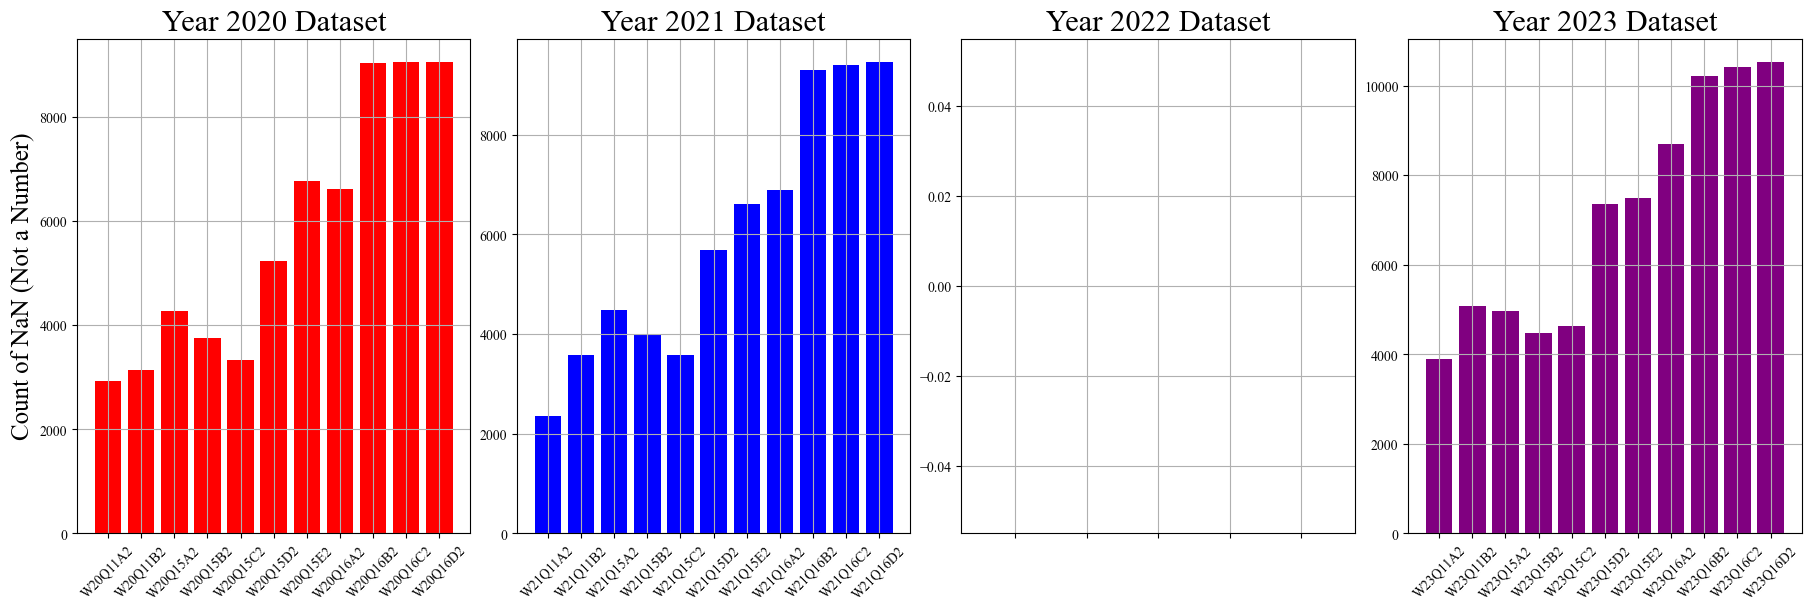

Check values - should be True : True
Dataset 2020's Nan value:  0 and shape : (9053, 26)
Dataset 2021's Nan value:  0 and shape : (9516, 26)
Dataset 2022's Nan value:  0 and shape : (9512, 26)
Dataset 2023's Nan value:  0 and shape : (10759, 26)


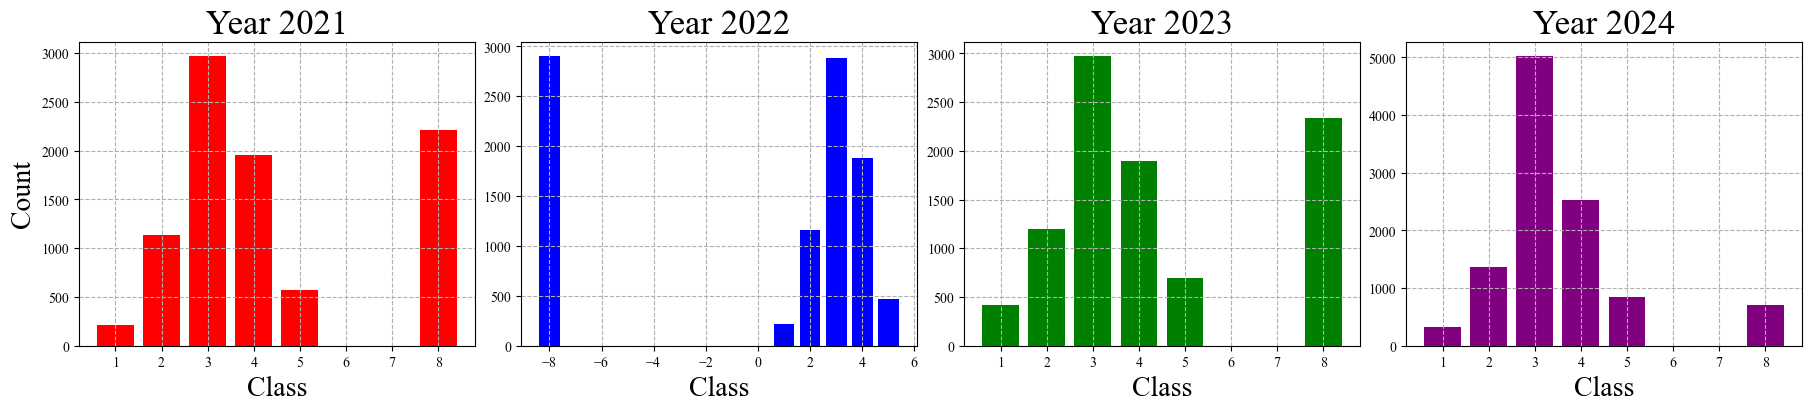

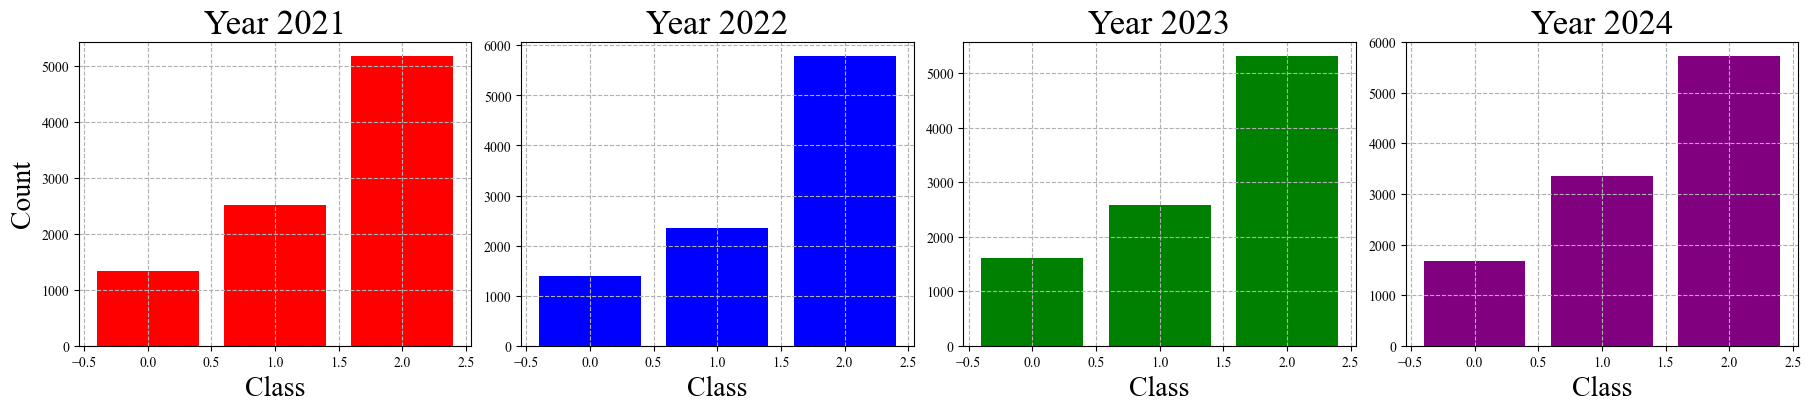

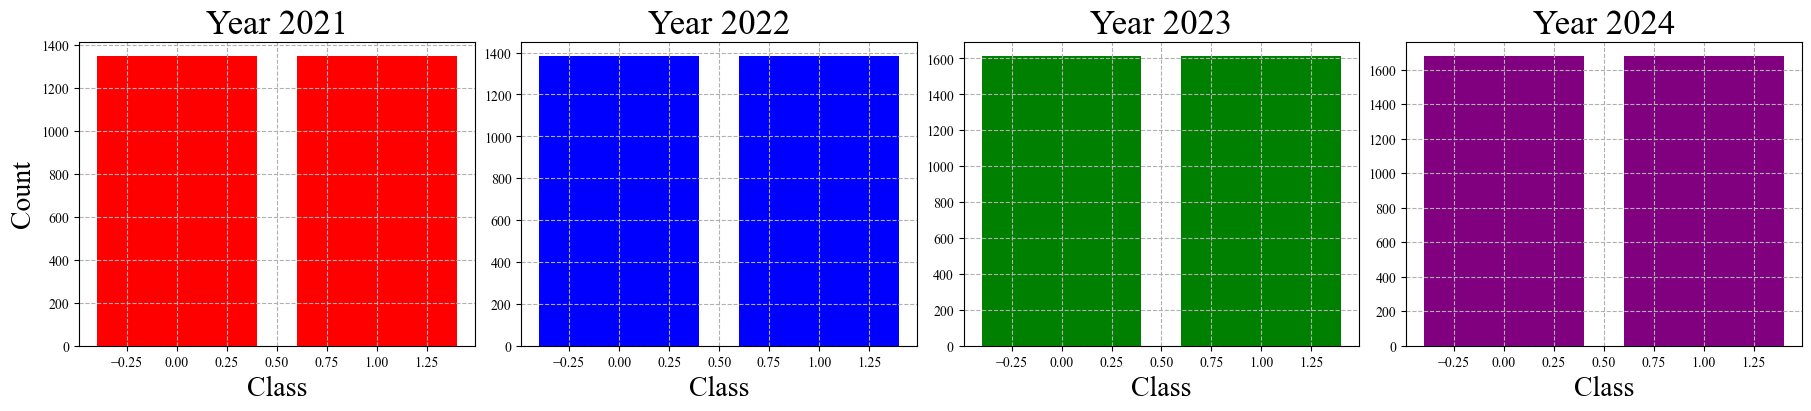

No string columns found in the DataFrame.
No string columns found in the DataFrame.
Test Accuracy (Same year) ========>  0.673469387755102
No string columns found in the DataFrame.
No string columns found in the DataFrame.
Model trained with Year 2020, testing with data from year 2020 => Accuracy : 0.673469387755102
No string columns found in the DataFrame.
No string columns found in the DataFrame.
Model trained with Year 2020, testing with data from year 2021 => Accuracy : 0.7093862815884476
No string columns found in the DataFrame.
No string columns found in the DataFrame.
Model trained with Year 2020, testing with data from year 2022 => Accuracy : 0.6656346749226006
No string columns found in the DataFrame.
No string columns found in the DataFrame.
Model trained with Year 2020, testing with data from year 2023 => Accuracy : 0.6577380952380952
No string columns found in the DataFrame.
No string columns found in the DataFrame.
Test Accuracy (Same year) ========>  0.6877256317689531
No

In [3]:
if __name__ == "__main__":

    for i in range(2020, 2024):
        globals()[f'Work_data_{i}'] = call_X_data(i, 'Work')
        globals()[f'Head_data_{i}'] = call_X_data(i, 'Head')
        print(globals()[f'Work_data_{i}'].shape, globals()[f'Head_data_{i}'].shape)

    path = './SPSS/'
    file_path = path+'Y_label.xlsx'  #Original dataset model with different name for flexible data input
    
    var = pd.read_excel(file_path, sheet_name='Items', engine='openpyxl')
    
    target_full_name = list(var.iloc[1,:])[2]
    target_2020 = list(var.iloc[1,:])[3]
    target_2021 = list(var.iloc[1,:])[4]
    target_2022 = list(var.iloc[1,:])[5]
    target_2023 = list(var.iloc[1,:])[6]    

    
    #X_df = var.iloc[2:, :] #All features
    X_df = var[var['분류'] == 'Feature_2']  # Selected features Only
    #X_df = var[var['분류'] == 'Feature_3' or var['분류'] == 'Feature_3']   # Selected features Only
    '''
    ['Q10A', 'Q10B', 'Q10C', 'Q10D', 'Q11A1', 'Q11B1', 'Q11A2', 'Q11B2', 'Q12A', 'Q12B', 'Q12C', 'Q13', 'Q14A', 'Q14B', 'Q14C', 'Q14D',
     'Q14E', 'Q14F', 'Q15A1', 'Q15B1', 'Q15C1', 'Q15D1', 'Q15E1', 'Q15A2', 'Q15B2', 'Q15C2', 'Q15D2', 'Q15E2', 'Q16A1', 'Q16B1', 'Q16C1',
     'Q16D1', 'Q16A2', 'Q16B2', 'Q16C2', 'Q16D2', 'Q17']
   ''' 
    
    X_var_name_2020 = X_df['변수명'].tolist()
    X_var_name_2021 = X_df['Unnamed: 4'].tolist()
    X_var_name_2022 = X_df['Unnamed: 5'].tolist()
    X_var_name_2023 = X_df['Unnamed: 6'].tolist()
    
    lst_data, cnt_data = [], []
    
    for i in range(2020, 2024):
        globals()[f'X_{i}'] = globals()[f'Work_data_{i}'][globals()[f'X_var_name_{i}']]
        print(f"{i} Dataset shape : ", globals()[f'X_{i}'].shape)        
        globals()[f'Nan_cols_{i}'], globals()[f'cnt_{i}'] = count_nan_and_extract_cols(globals()[f'X_{i}'].isna().sum())
        
        lst_data.append(globals()[f'Nan_cols_{i}']) 
        cnt_data.append(globals()[f'cnt_{i}'])
        
    draw_fig_check_nan(lst_data, cnt_data)
    
    Nan_col_check_2020 = [item.replace('W20', '') for item in Nan_cols_2020]
    Nan_col_check_2021 = [item.replace('W21', '') for item in Nan_cols_2021]
    Nan_col_for_2022 = [item.replace('W20', 'W22') for item in Nan_cols_2020] #to maintain coherence
    Nan_col_check_2023 = [item.replace('W23', '') for item in Nan_cols_2023]

    tmp = Nan_col_check_2020 == Nan_col_check_2021 == Nan_col_check_2023
    if tmp: print("Check values - should be True :", tmp) #Identical columns that involves Nan
    else: raise ValueError("Columns are not identical or contain different NaN values.")
    
    
    for i in range(2020, 2024):
        globals()[f'X_{i}_cleaned'] = globals()[f'X_{i}'].drop(columns=globals()[f'Nan_cols_{i}'])
        if i == 2022:
            globals()[f'X_{i}_cleaned'] = globals()[f'X_{i}'].drop(columns=Nan_col_for_2022)
            
        print(f"Dataset {i}'s Nan value: ", globals()[f'X_{i}_cleaned'].isna().sum().sum(), f"and shape : {globals()[f'X_{i}_cleaned'].shape}")
    #X_2020_cleaned
    
    draw_fig_class_check([Work_data_2020, Work_data_2021, Work_data_2022, Work_data_2023], [target_2020, target_2021, target_2022, target_2023])

    for i in range(4):
        tmp = globals()[f'Work_data_202{i}'][globals()[f'target_202{i}']]
        tmp_lst = []
        
        for v in tmp:
            if v == 1 or v == 2: tmp_lst.append(0)
            elif v == 4 or v == 5: tmp_lst.append(1)
            else: tmp_lst.append(2)
        
        globals()[f'Y_202{i}'] = pd.Series(tmp_lst)

    draw_fig_class([Y_2020, Y_2021, Y_2022, Y_2023])

    for i in range(2020, 2024):
        y_df = pd.DataFrame(globals()[f'Y_{i}'], columns=['Target'])
        
        globals()[f'final_data_{i}'] = pd.concat([globals()[f'X_{i}_cleaned'], y_df], axis=1)
        num_val = globals()[f'final_data_{i}']['Target'].value_counts().values[-1]
        
        class_0_samples = globals()[f'final_data_{i}'][globals()[f'final_data_{i}']['Target'] == 0].sample(n=num_val, random_state=42)
        class_1_samples = globals()[f'final_data_{i}'][globals()[f'final_data_{i}']['Target'] == 1].sample(n=num_val, random_state=42)
        
        selected_data = pd.concat([class_0_samples, class_1_samples], axis=0).reset_index(drop=True)
        
        globals()[f'selected_data_{i}'] = selected_data

    
    draw_fig_class([selected_data_2020['Target'], selected_data_2021['Target'], selected_data_2022['Target'], selected_data_2023['Target']])

    scaler = StandardScaler()

    for i in range(4):
        X = globals()[f'selected_data_202{i}'].drop(columns=['Target']) 
        #X = pd.DataFrame(scaler.fit_transform(X_unnorm), columns=X_unnorm.columns)
        X.columns = X.columns.str.replace(f'W2{i}', '', regex=False)  ##Important for generalization
        Y = globals()[f'selected_data_202{i}']['Target']
        
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        
        Check_String(X_train)
        Check_String(X_test)    

        model = build_model()
        model = train_test_model(model, X_train, y_train, X_test, y_test)
        feature_importance_save(model)

        
        for j in range(i, 4):
            X = globals()[f'selected_data_202{j}'].drop(columns=['Target']) 
            #X = pd.DataFrame(scaler.fit_transform(X_unnorm), columns=X_unnorm.columns)
            X.columns = X.columns.str.replace(f'W2{j}', '', regex=False)  ##Important for generalization
            Y = globals()[f'selected_data_202{j}']['Target']
            
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        
            Check_String(X_train)
            Check_String(X_test)
            
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Model trained with Year 202{i}, testing with data from year 202{j} => Accuracy : {accuracy}")
    
            permutation_importance_save(model, X_test, y_test, i, j)
            

my_project/
│
├── main.py              # Main script that runs the overall pipeline
├── data_preprocessing.py # Functions related to data loading, cleaning, and preprocessing
├── model.py             # Model building and training functions
├── evaluation.py        # Evaluation and performance functions (accuracy, feature importance, etc.)
├── utils.py             # Utility functions like checks and plotting
└── requirements.txt     # Dependencies file